In [ ]:
# 1. Install all system dependencies (with -y to auto-confirm)
!apt-get update
!apt-get install -y xvfb x11-xserver-utils
!apt-get install -y \
    libx11-6 \
    libxau6 \
    libxdmcp6 \
    libxcb1 \
    libxext6 \
    libx11-xcb1 \
    libvulkan1 \
    vulkan-utils \
    libvulkan-dev \
    mesa-vulkan-drivers

# 2. Install Python packages
!pip install --upgrade mani_skill tyro pyvirtualdisplay

# 3. Verify Xvfb is installed
!which Xvfb

# 4. Setup virtual display
from pyvirtualdisplay import Display
virtual_display = Display(visible=0, size=(1024, 768))
virtual_display.start()

# Other added
!pip install ipywidgets
!jupyter nbextension enable --py widgetsnbextension

import mani_skill
print(f"ManiSkill version: {mani_skill.__version__}")
print(f"ManiSkill location: {mani_skill.__file__}")

In [73]:
from mani_skill.utils.download_asset import download
from mani_skill.utils.assets import DATA_SOURCES

# First download the cabinet asset
data_source = DATA_SOURCES["partnet_mobility/1030"]
download(data_source, verbose=True, non_interactive=True)

0.00iB [00:00, ?iB/s]

  0%|          | 0/231 [00:00<?, ?it/s]

PosixPath('/root/.maniskill/data/partnet_mobility/dataset/1030')

In [89]:
from typing import Any, Dict, Union

import numpy as np
import sapien
import torch
import torch.random
from transforms3d.euler import euler2quat

from mani_skill.agents.robots import Fetch, Panda
from mani_skill.envs.sapien_env import BaseEnv
from mani_skill.sensors.camera import CameraConfig
from mani_skill.utils import common, sapien_utils
from mani_skill.utils.building import actors
from mani_skill.utils.registration import register_env
from mani_skill.utils.scene_builder.table import TableSceneBuilder
from mani_skill.utils.structs import Pose
from mani_skill.utils.structs.types import Array, GPUMemoryConfig, SimConfig
from mani_skill.utils.building import articulations

In [102]:
from typing import Any, Dict


from torch import Tensor


@register_env("PushCube-v1", max_episode_steps=50)
class PushCubeEnv(BaseEnv):

    SUPPORTED_ROBOTS = ["panda","fetch"]

    agent: Union[Panda,Fetch]
    goal_radius = 0.1
    cube_half_size = 0.02

    # Specify default simulation/gpu memory configurations to override any default values
    @property
    def _default_sim_config(self):
        return SimConfig(
            gpu_memory_config=GPUMemoryConfig(
                found_lost_pairs_capacity=2**25, max_rigid_patch_count=2**18
            )
        )

    @property
    def _default_sensor_configs(self):
        # registers one 128x128 camera looking at the robot, cube, and target
        # a smaller sized camera will be lower quality, but render faster
        pose = sapien_utils.look_at(eye=[0.3, 0, 0.6], target=[-0.1, 0, 0.1])
        return [
            CameraConfig(
                "base_camera",
                pose=pose,
                width=128,
                height=128,
                fov=np.pi / 2,
                near=0.01,
                far=100,
            )
        ]

    @property
    def _default_human_render_camera_configs(self):
        # registers a more high-definition (512x512) camera used just for rendering when render_mode="rgb_array" or calling env.render_rgb_array()
        pose = sapien_utils.look_at([0.6, 0.7, 0.6], [0.0, 0.0, 0.35])
        return CameraConfig(
            "render_camera", pose=pose, width=512, height=512, fov=1, near=0.01, far=100
        )



    def __init__(self,*args,robot_uids="panda",robot_init_qpos_noise=0.02,**kwargs):
        self.robot_init_qpos_noise = robot_init_qpos_noise
        super().__init__(*args,robot_uids=robot_uids,**kwargs) 

    def _load_scene(self,options:dict):
        self.table_scene = TableSceneBuilder(
            env=self,robot_init_qpos_noise=self.robot_init_qpos_noise
        )
        self.table_scene.build() # what does this line do?

        self.obj = actors.build_cube(
            self.scene,
            half_size = self.cube_half_size,
            color = np.array([12,42,160,255])/255,
            name="cube",
            body_type="dynamic",
            initial_pose=sapien.Pose(p=[0,0,self.cube_half_size])
        )

        #testing
        self.obj = actors.build_sphere(
            self.scene,
            radius = 0.05,
            color=np.array([0,255,0,255])/255,
            name="test_sphere",
            body_type="dynamic",
            initial_pose=sapien.Pose(p=[0,0,0.5])
        )

        self.goal_region = actors.build_red_white_target(
            self.scene,
            radius = self.goal_radius,
            thickness = 1e-5,
            name="goal_region",
            add_collision=False,
            body_type="kinematic",
            initial_pose=sapien.Pose(p=[0,0,1e-3])
        )

        # # not relevant to push_cube. just trying out importing actors 
        # not working "no dataset named partnet-mobility"
        # builder = actors.get_actor_builder(
        #     self.scene,
        #     id = "partnet-mobility:1030"
        # )
        # builder.initial_pose = sapien.Pose(p=[0,0,0.5])
        # builder.build(name="cabinet")

        # loading articulation
        builder = articulations.get_articulation_builder(
            self.scene, f"partnet-mobility:{1030}"
        )
        builder.inital_pose = sapien.Pose(p=[0, 0, 0.5])
        builder.build(name="object")


    def _load_agent(self,options:dict):
        super()._load_agent(options,sapien.Pose(p=[-0.615,0,0]))

    def _initialize_episode(self,env_idx:torch.Tensor,options:dict):
        with torch.device(self.device):
            # why would you only want to reinitialize some of the envs
            b = len(env_idx)
            self.table_scene.initialize(env_idx)

            # xy coordinates are randomized and z is set to half_size
            xyz = torch.zeros((b,3))
            xyz[...,:2] = torch.rand((b,2)) * 0.2 - 0.1
            xyz[...,2] = self.cube_half_size
            q = [1,0,0,0]

            obj_pose = Pose.create_from_pq(p=xyz,q=q)
            self.obj.set_pose(obj_pose)

            # some weird math positioning
            # need to read up on why quarternions are better for representing rotations
            target_region_xyz = xyz + torch.tensor([0.1 + self.goal_radius,0,0])
            target_region_xyz[...,2] = 1e-3
            self.goal_region.set_pose(
                Pose.create_from_pq(
                    p=target_region_xyz,
                    q=euler2quat(0,np.pi/2,0)
                )
            )


    def evaluate(self):
        is_obj_placed = (
            torch.linalg.norm(
                self.obj.pose.p[...,:2] - self.goal_region.pose.p[...,:2],axis=1
            ) < self.goal_radius
        )

        # implementing fail condition
        is_failed = (
            self.obj.pose.p[...,2]<1
        )
    

        return {
            "success": is_obj_placed,
            "fail": is_failed,
            }

    def _get_obs_extra(self,info:Dict):
        obs = dict(
            tcp_pose=self.agent.tcp.pose.raw_pose,
        )
        if self.obs_mode in ["state","state_dict"]:
            obs.update(
                goal_pos = self.goal_region.pose.p,
                obj_pose = self.obj.pose.raw_pose,
            )
        return obs

    def compute_dense_reward(self, obs: Any, action: Array, info: Dict):
        # We also create a pose marking where the robot should push the cube from that is easiest (pushing from behind the cube)
        tcp_push_pose = Pose.create_from_pq(
            p=self.obj.pose.p
            + torch.tensor([-self.cube_half_size - 0.005, 0, 0], device=self.device)
        )
        tcp_to_push_pose = tcp_push_pose.p - self.agent.tcp.pose.p
        tcp_to_push_pose_dist = torch.linalg.norm(tcp_to_push_pose, axis=1)
        reaching_reward = 1 - torch.tanh(5 * tcp_to_push_pose_dist)
        reward = reaching_reward

        # compute a placement reward to encourage robot to move the cube to the center of the goal region
        # we further multiply the place_reward by a mask reached so we only add the place reward if the robot has reached the desired push pose
        # This reward design helps train RL agents faster by staging the reward out.
        reached = tcp_to_push_pose_dist < 0.01
        obj_to_goal_dist = torch.linalg.norm(
            self.obj.pose.p[..., :2] - self.goal_region.pose.p[..., :2], axis=1
        )
        place_reward = 1 - torch.tanh(5 * obj_to_goal_dist)
        reward += place_reward * reached

        # assign rewards to parallel environments that achieved success to the maximum of 3.
        reward[info["success"]] = 3
        return reward

    def compute_normalized_dense_reward(self, obs: Any, action: Array, info: Dict):
        # this should be equal to compute_dense_reward / max possible reward
        max_reward = 3.0
        return self.compute_dense_reward(obs=obs, action=action, info=info) / max_reward

2025-01-16 08:46:54,064 - mani_skill  - WARNING - Env PushCube-v1 is already registered. Skip registration.


In [103]:
from pyvirtualdisplay import Display
virtual_display = Display(visible=0, size=(1400, 900))
virtual_display.start()

env = PushCubeEnv()
env.reset()
env.render_mode = "rgb_array"

for episode in range(3):
    obs = env.reset()
    ep_reward = 0
    
    for step in range(50):
        action = env.action_space.sample()
        obs,reward,terminated,truncated,info = env.step(action)
        ep_reward += reward
        
        env.render()
        
        if terminated:
            print(f"Episode {episode + 1} finished with reward: {ep_reward}")
            print(f"Success: {info['success']}, Failed: {info['fail']}")
            break
env.close()

2025-01-16 08:46:55,217 - mani_skill  - WARNING - No initial pose set for articulation builder of object, setting to default pose q=[1,0,0,0], p=[0,0,0]. There may be simulation issues/bugs if this articulation at it's initial pose collides with other objects at their initial poses.


Episode 1 finished with reward: tensor([0.0883])
Success: tensor([False]), Failed: tensor([True])
Episode 2 finished with reward: tensor([0.1222])
Success: tensor([False]), Failed: tensor([True])
Episode 3 finished with reward: tensor([0.1785])
Success: tensor([False]), Failed: tensor([True])


2025-01-16 08:46:56,003 - mani_skill  - WARNING - No initial pose set for articulation builder of object, setting to default pose q=[1,0,0,0], p=[0,0,0]. There may be simulation issues/bugs if this articulation at it's initial pose collides with other objects at their initial poses.


Render frame shape: torch.Size([512, 512, 3])


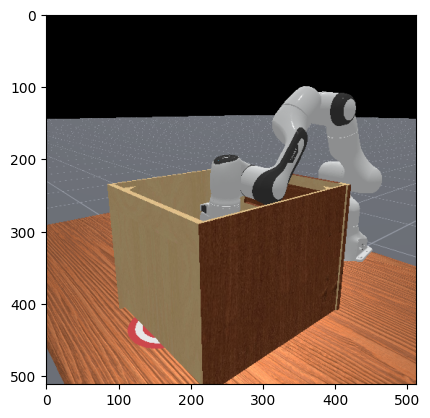

In [104]:
env = PushCubeEnv()
env.render_mode = "rgb_array"
obs = env.reset()
frame = env.render()
frame = frame.squeeze()
print(f"Render frame shape: {frame.shape if frame is not None else None}")
plt.imshow(frame)
plt.show()


In [30]:
from tqdm.notebook import tqdm
from mani_skill.utils.wrappers import RecordEpisode


from pyvirtualdisplay import Display
virtual_display = Display(visible=0, size=(1400, 900))
virtual_display.start()

env = PushCubeEnv()
env.render_mode = "rgb_array"
obs = env.reset()

env = RecordEpisode(
    env,
    './push_cube_videos',
    max_steps_per_video=500
)

obs = env.reset()
for i in tqdm(range(500)):
    action = env.action_space.sample()
    obs, reward, terminated, truncated, info = env.step(action)
    # env.render_human() # will render with a window if possible
env.close()
from IPython.display import Video
Video("./push_cube_videos/0.mp4", embed=True, width=640) # Watch our replay

2025-01-16 07:41:43,946 - mani_skill  - WARNING - mani_skill is not installed with git.


  0%|          | 0/500 [00:00<?, ?it/s]

In [34]:
!python -m mani_skill2.utils.download_asset

/opt/conda/bin/python: Error while finding module specification for 'mani_skill2.utils.download_asset' (ModuleNotFoundError: No module named 'mani_skill2')


In [36]:
from mani_skill.utils.building import actors
from mani_skill.envs.sapien_env import BaseEnv
from mani_skill.utils.registration import register_env

# First download the asset
!python -m mani_skill2.utils.download_asset ycb:004_sugar_box

# Then create a simple test environment
@register_env("TestYCB-v0")
class TestYCBEnv(BaseEnv):
    def _load_scene(self, options: dict):
        # Create a sugar box
        builder = actors.get_actor_builder(
            self.scene,
            id="ycb:004_sugar_box"
        )
        builder.initial_pose = sapien.Pose(p=[0, 0, 0.5])
        self.box = builder.build(name="sugar_box")

    def _load_agent(self, options: dict):
        pass  # No robot needed for this test

# Create and visualize the environment
env = TestYCBEnv()
env.render_mode = "rgb_array"
obs = env.reset()
frame = env.render()

# Display the result
import matplotlib.pyplot as plt
plt.imshow(frame)
plt.show()

/opt/conda/bin/python: Error while finding module specification for 'mani_skill2.utils.download_asset' (ModuleNotFoundError: No module named 'mani_skill2')


FileNotFoundError: [Errno 2] No such file or directory: '/root/.maniskill/data/assets/mani_skill2_ycb/info_raw.json'

In [50]:
from mani_skill.utils.assets import DATA_SOURCES
from mani_skill.utils.download_asset import download

# Download the YCB sugar box
data_source = DATA_SOURCES["ycb:004_sugar_box"]
download(data_source, verbose=True, non_interactive=True)

KeyError: 'ycb:004_sugar_box'

In [51]:
from mani_skill.utils.assets import DATA_SOURCES, DATA_GROUPS

# List available assets
print("Available asset groups:")
print(list(DATA_GROUPS.keys()))

print("\nAvailable YCB objects:")
ycb_assets = [k for k in DATA_SOURCES.keys() if k.startswith("ycb:")]
print(ycb_assets)

Available asset groups:
['partnet_mobility_cabinet', 'partnet_mobility_chair', 'partnet_mobility_bucket', 'partnet_mobility_faucet', 'partnet_mobility', 'allegro_hand_right', 'allegro_hand_left', 'allegro_hand_right_touch', 'anymal_c', 'dclaw', 'fetch', 'floating_panda_gripper', 'floating_robotiq_2f_85_gripper', 'googlerobot', 'humanoid', 'panda', 'panda_wristcam', 'panda_stick', 'stompy', 'trifingerpro', 'unitree_g1', 'unitree_g1_simplified_legs', 'unitree_g1_simplified_upper_body', 'unitree_g1_simplified_upper_body_with_head_camera', 'unitree_g1_simplified_upper_body_right_arm', 'unitree_go2', 'unitree_go2_simplified_locomotion', 'unitree_h1', 'unitree_h1_simplified', 'ur_10e', 'widowx250s', 'xarm7_ability', 'xmate3_robotiq', 'SceneManipulation-v1', 'ArchitecTHOR_SceneManipulation-v1', 'ReplicaCAD_SceneManipulation-v1', 'ReplicaCADTidyHouseTrain_SceneManipulation-v1', 'ReplicaCADTidyHouseVal_SceneManipulation-v1', 'ReplicaCADPrepareGroceriesTrain_SceneManipulation-v1', 'ReplicaCADPre

In [66]:
from mani_skill.utils.assets.data import (
    DATA_GROUPS, 
    DATA_SOURCES,
    expand_data_group_into_individual_data_source_ids
)

# Let's check what's in some interesting groups
for group in ['partnet_mobility_cabinet', 'ReplicaCADPrepareGroceriesTrain_SceneManipulation-v1']:
    print(f"\nAssets in {group}:")
    asset_ids = expand_data_group_into_individual_data_source_ids(group)
    print(asset_ids)


Assets in partnet_mobility_cabinet:
['partnet_mobility/1030', 'partnet_mobility/1028', 'partnet_mobility/1077', 'partnet_mobility/1046', 'partnet_mobility/1073', 'partnet_mobility/1042', 'partnet_mobility/1047', 'partnet_mobility/1004', 'partnet_mobility/1061', 'partnet_mobility/1054', 'partnet_mobility/1016', 'partnet_mobility/1082', 'partnet_mobility/1062', 'partnet_mobility/1013', 'partnet_mobility/1078', 'partnet_mobility/1027', 'partnet_mobility/1005', 'partnet_mobility/1076', 'partnet_mobility/1068', 'partnet_mobility/1000', 'partnet_mobility/1052', 'partnet_mobility/1024', 'partnet_mobility/1063', 'partnet_mobility/1031', 'partnet_mobility/1017', 'partnet_mobility/1036', 'partnet_mobility/1006', 'partnet_mobility/1032', 'partnet_mobility/1044', 'partnet_mobility/1026', 'partnet_mobility/1002', 'partnet_mobility/1034', 'partnet_mobility/1018', 'partnet_mobility/1060', 'partnet_mobility/1041', 'partnet_mobility/1081', 'partnet_mobility/1039', 'partnet_mobility/1021', 'partnet_mob

In [74]:
# 1. First download the cabinet asset
from mani_skill.utils.download_asset import download
from mani_skill.utils.assets import DATA_SOURCES

data_source = DATA_SOURCES["partnet_mobility/1030"]
download(data_source, verbose=True, non_interactive=True)

# 2. Then create and run the environment
from pyvirtualdisplay import Display
virtual_display = Display(visible=0, size=(1400, 900))
virtual_display.start()

env = PushCubeEnv()
env.reset()
env.render_mode = "rgb_array"

0.00iB [00:00, ?iB/s]

  0%|          | 0/231 [00:00<?, ?it/s]

RuntimeError: No dataset with id partnet_mobility/1030 was found

In [75]:
from mani_skill.utils.download_asset import download
from mani_skill.utils.assets import DATA_SOURCES
import os

# 1. Check what we're trying to download
data_source = DATA_SOURCES["partnet_mobility/1030"]
print(f"Data source info: {data_source}")

# 2. Download with verbose output
output_path = download(data_source, verbose=True, non_interactive=True)
print(f"Download output path: {output_path}")

# 3. Check if files exist
if output_path and os.path.exists(output_path):
    print(f"Files in download directory:")
    print(os.listdir(output_path))
else:
    print(f"Output path does not exist: {output_path}")

# 4. Print the expected asset search paths
print("\nAsset search paths:")
print(os.environ.get('MANISKILL_ASSET_PATH', 'Not set'))
print(os.path.expanduser('~/.maniskill/data'))

Data source info: DataSource(source_type='objects', url='https://storage1.ucsd.edu/datasets/ManiSkill2022-assets/partnet_mobility/dataset/1030.zip', hf_repo_id=None, github_url=None, target_path=PosixPath('/root/.maniskill/data/partnet_mobility/dataset/1030'), checksum=None, zip_dirname=None, filename=None, output_dir=PosixPath('/root/.maniskill/data'))


0.00iB [00:00, ?iB/s]

  0%|          | 0/231 [00:00<?, ?it/s]

Download output path: /root/.maniskill/data/partnet_mobility/dataset/1030
Files in download directory:
['mobility.urdf', 'point_sample', 'meta.json', 'tree_hier.html', 'images', 'bounding_box.json', 'parts_render_after_merging', 'semantics.txt', 'mobility_cvx.urdf', 'parts_render', 'tree_hier_after_merging.html', 'mobility_v2.json', 'result_after_merging.json', 'result.json', 'cvx_objs', 'textured_objs']

Asset search paths:
Not set
/root/.maniskill/data


In [86]:
from mani_skill.utils.building.actors import get_actor_builder
from mani_skill.utils.assets.data import DATA_SOURCES, DATA_GROUPS

# Print all available dataset sources
print("Available data sources:")
for key in DATA_SOURCES.keys():
    print(f"- {key}")

print("\nAvailable data groups:")
for key in DATA_GROUPS.keys():
    print(f"- {key}")

Available data sources:
- ycb
- pick_clutter_ycb_configs
- assembling_kits
- panda_avoid_obstacles
- bridge_v2_real2sim
- partnet_mobility/1021
- partnet_mobility/1027
- partnet_mobility/1004
- partnet_mobility/1013
- partnet_mobility/1000
- partnet_mobility/1061
- partnet_mobility/1040
- partnet_mobility/1032
- partnet_mobility/1005
- partnet_mobility/1054
- partnet_mobility/1052
- partnet_mobility/1056
- partnet_mobility/1044
- partnet_mobility/1038
- partnet_mobility/1033
- partnet_mobility/1079
- partnet_mobility/1024
- partnet_mobility/1063
- partnet_mobility/1045
- partnet_mobility/1067
- partnet_mobility/1035
- partnet_mobility/1076
- partnet_mobility/1066
- partnet_mobility/1082
- partnet_mobility/1016
- partnet_mobility/1051
- partnet_mobility/1057
- partnet_mobility/1014
- partnet_mobility/1018
- partnet_mobility/1065
- partnet_mobility/1047
- partnet_mobility/1026
- partnet_mobility/1031
- partnet_mobility/1077
- partnet_mobility/1007
- partnet_mobility/1025
- partnet_mobili